<div class="alert alert-info">
    <font size="5"><b>Формирование модели монетизации в игре "Космические братья"</b></font>

Презентация : https://disk.yandex.ru/i/U9hWsI7V1zCmpg

# Table of contents
1. [Вводная информация](#intro)
2. [Часть 1. Проверка и подготовка данных](#paragraph1)
3. [Часть 2. Анализ данных](#paragraph2)
5. [Часть 3. Гипотезы](#paragraph3)
5. [Часть 4. Формирование модели монетизации](#paragraph4)
5. [Часть 5. Выводы и рекомендации](#paragraph5)

# Вводная информация<a name="intro"></a>


### **Описание датасетов:**

Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.



**Датасет *game_actions.csv*:**

- `event_datetime` — время события;


- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
    
    
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
    
    
- `user_id` — идентификатор пользователя;


- `project_type` — тип реализованного проекта;

**Датасет *ad_cost.csv* содержит колонки:**

- `day` - день, в который был совершен клик по объявлению


- `source` - источник трафика


- `cost` - стоимость кликов

**Датасет user_source.csv содержит колонки:**

- `user_id` - идентификатор пользователя


- `source` - источников, с которого пришёл пользователь, установивший приложение

### Задача**:**

**Сформировать модель монетизации игрового приложения.**

1. Проведисти исследовательский анализ данных

2. Проанализируйте влияние событий на совершение целевого события

3. Проверка статистических гипотез

## Проверка и подготовка данных
<a class="anchor" id="paragraph1"></a>

### Загрузка библиотек и датасетов. 

In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import datetime as dt
import math
from datetime import datetime, timedelta
from scipy import stats as st

In [3]:
try: 
    ad_cost = pd.read_csv('/datasets/ad_costs.csv')
    game_actions = pd.read_csv('/datasets/game_actions.csv')
    user_source = pd.read_csv('/datasets/user_source.csv')
except FileNotFoundError:
    ad_cost = pd.read_csv('C:/Users/C/project/final_project/ad_costs.csv')
    game_actions = pd.read_csv('C:/Users/C/project/final_project/game_actions.csv')
    user_source = pd.read_csv('C:/Users/C/project/final_project/user_source.csv')
    

### Функции для расчета и визуализации

In [4]:
def get_profiles(sessions, orders, ad_cost, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'event_datetime'])
        .groupby('user_id')
        .agg(
            {
                'event_datetime': 'first',
                'source': 'first',
                'lvlup' : 'first',
                'condition' : 'first'
            }
        )
        .rename(columns={'event_datetime': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    profiles['day'] = profiles['first_ts'].dt.date
    profiles['day'] = pd.to_datetime(profiles['day'])
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['day', 'source'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_cost = ad_cost.merge(new_users, on=['day', 'source'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_cost['acquisition_cost'] = ad_cost['cost'] / ad_cost['unique_users']
    
    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_cost[['day', 'source', 'acquisition_cost']],
        on=['day', 'source'],
        how='left',
    )

    return profiles

In [5]:
# Функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    #dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('day <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'event_datetime']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_datetime'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['day'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [6]:
# Функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]
    
    ax1 = plt.subplot(2, 2, 1)
    retention.T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание пользователей')

    
    plt.tight_layout()
    plt.show() 

In [7]:
# Функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('day <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_datetime', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_datetime'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['day'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [8]:
# Функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [9]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 7))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]
    colors=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'm']

    # график — кривые ltv
    ax1 = plt.subplot(1, 2, 1)
    ltv.T.plot(grid=True, ax=ax1, color=colors)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # график — кривые roi
    ax4 = plt.subplot(1, 2, 2)
    roi.T.plot(grid=True, ax=ax4, color=colors)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')


    plt.tight_layout()
    plt.show() 

### Проверка данных и подготовка данных.

In [10]:
display(game_actions.head(5))

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


In [11]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


In [12]:
# Проверка на наличие дубликатов
display(game_actions['building_type'].value_counts())
display(game_actions['event'].value_counts())
display(game_actions['project_type'].value_counts())

spaceport          59325
assembly_shop      54494
research_center    14138
Name: building_type, dtype: int64

building            127957
finished_stage_1      5817
project               1866
Name: event, dtype: int64

satellite_orbital_assembly    1866
Name: project_type, dtype: int64

In [13]:
# Перевожу время в datetime
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
# Проверяю мин и макс значения дат
display(game_actions['event_datetime'].min(), game_actions['event_datetime'].max())

Timestamp('2020-05-04 00:00:01')

Timestamp('2020-06-05 12:32:49')

In [14]:
display(user_source.head(5))

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


In [15]:
# Проверка на наличие дубликатов
display(user_source['source'].value_counts())

yandex_direct              4817
instagram_new_adverts      3347
facebook_ads               2726
youtube_channel_reklama    2686
Name: source, dtype: int64

In [16]:
display(ad_cost)
display(ad_cost.info())

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796
5,facebook_ads,2020-05-08,68.009276
6,facebook_ads,2020-05-09,38.723350
7,instagram_new_adverts,2020-05-03,943.204717
8,instagram_new_adverts,2020-05-04,502.925451
9,instagram_new_adverts,2020-05-05,313.970984


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


None

In [17]:
# Перевожу время в datetime
ad_cost['day'] = pd.to_datetime(ad_cost['day'])

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Дубликатов нет.
- Пропуски намеренные и действительно означают отсутствие значения.
- Время было в формате object, перевел в datetime.
</div>

In [18]:
# Добавляю источник привлечения для каждого пользователя
game_actions = game_actions.merge(user_source, on='user_id', how='outer')

In [19]:
# Добавляю дату первого действия для каждого клиента и дельту с этой датой для каждого действия
first_action = (
    game_actions.groupby('user_id')
    .agg({'event_datetime': 'min'}, asindex=False)
    .reset_index()
    .sort_values(by='event_datetime')
)
first_action = first_action.rename(columns = {'event_datetime' : 'first_action'})

In [20]:
# Добавляю эти даты в общие данные
game_actions = game_actions.merge(first_action, on='user_id', how='left')

In [21]:
# Проверяю, что даты привлечения совпадают с датами рекламы.
pd.to_datetime(game_actions['first_action']).dt.date.value_counts()

2020-05-04    64226
2020-05-05    34757
2020-05-06    17399
2020-05-07     9429
2020-05-08     5121
2020-05-09     3025
2020-05-10     1683
Name: first_action, dtype: int64

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Все игроки сделали первое действие в течение недели. Так как реклама оплачивалась авансом есть смещение в 1 день.
</div>

In [22]:
# Добавляю один день к рекламе, таким образом деньги выплаченные авансом попадают на тот день, на который они были выделены.
ad_cost['day'] = ad_cost['day'] + pd.Timedelta(days=1)

In [23]:
# Проверка, что даты совпадают с датами выше.
ad_cost['day'].value_counts()

2020-05-05    4
2020-05-09    4
2020-05-06    4
2020-05-10    4
2020-05-07    4
2020-05-04    4
2020-05-08    4
Name: day, dtype: int64

In [24]:
# Добавляю колонку с дельтой времени в днях между первым действием и действием в строке.
game_actions['time_delta'] = (game_actions['event_datetime'] - game_actions['first_action']).dt.days.astype(int)

In [25]:
# Создаю отдельный датафрейм с теми, кто перешел на следующий уровень.
game_finished = game_actions[game_actions['event'] == 'finished_stage_1']

In [26]:
# Список с теми, кто перешел на следующий уровень через проект.
game_finished_project_ids = game_actions[game_actions['project_type'] == 'satellite_orbital_assembly']['user_id'].to_list()
# Список с теми, кто перешел на следующий уровень
game_finished_ids = game_finished['user_id'].to_list()

In [27]:
# Отдельные датасеты с разными условиями лвл-апа
game_finished_battle = game_finished.query('user_id not in @game_finished_project_ids')
game_finished_project = game_finished.query('user_id in @game_finished_project_ids')

In [28]:
print('Проверка, что пользователи не переходили на следующий уровень больше 1 раза.')
print(len(game_finished) == game_finished['user_id'].nunique())

Проверка, что пользователи не переходили на следующий уровень больше 1 раза.
True


In [29]:
print('Проверка, что пользователь дважды не был привлечен рекламой.')
print(len(user_source) == user_source['user_id'].nunique())

Проверка, что пользователь дважды не был привлечен рекламой.
True


In [30]:
# Добавляю даты привлечения в таблицу с источниками привлечения.
user_source = user_source.merge(first_action, on='user_id', how='outer')

In [31]:
# Проверка, что каждый игрок построил хотя бы одно здание (в данном случае assembly_shop)
game_actions.pivot_table(index='user_id', columns='building_type', values='event', aggfunc='count').isna().sum()

building_type
assembly_shop         0
research_center    5905
spaceport           345
dtype: int64

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
    
- Все проверки указывают на то, что данные верны и можно приступать к анализу.
- Каждый игрок хотя бы раз строил здание.
- Расходы на рекламу сдвинуты на 1 день, чтобы выпадать на дату, в которую получаем прибыль с этой рекламы.
</div>

## Исследовательский анализ данных
<a class="anchor" id="paragraph2"></a>

In [32]:
# Возьмем горизонт в 21 день, чтобы лайфтайм всех участников был сопоставим
observation_date = datetime(2020, 6, 6).date()  # момент анализа
horizon_days = 21  # горизонт анализа

In [33]:
# Предположим, что реклама появляется каждый раз при открытии окна постройки. Посчитаем потенциальную прибыль при таком подходе.
# Сколько мы получаем с клиента, которому не показывается реклама
default_no_ad_revenue = 0
# Сколько мы получаем с клиента, которому показывается реклама
default_ad_revenue = 0.07
game_actions['revenue'] = default_no_ad_revenue
game_actions.loc[game_actions['event'] == 'building', 'revenue'] = default_ad_revenue
game_actions.loc[game_actions['event'] != 'building', 'revenue'] = default_no_ad_revenue

In [34]:
payments = game_actions[['user_id', 'event_datetime', 'revenue']]

In [35]:
# Добавляю параметр лвл-ап
game_finished['lvlup'] = True
game_actions = game_actions.merge(game_finished[['user_id', 'lvlup']], on='user_id', how='outer')
game_actions['lvlup'] = game_actions['lvlup'].fillna('False')

In [36]:
# Добавляю условие лвл-апа
game_finished_battle['condition_battle'] = 'battle'
game_finished_project['condition_project'] = 'project'
game_actions = game_actions.merge(game_finished_battle[['user_id', 'condition_battle']], on='user_id', how='left')
game_actions = game_actions.merge(game_finished_project[['user_id', 'condition_project']], on='user_id', how='left')

In [37]:
conditions = [
    (game_actions['condition_battle'] == 'battle'),
    (game_actions['condition_project'] == 'project')
]
choices = ['battle', 'project']
game_actions['condition'] = np.select(conditions, choices)
game_actions = game_actions.drop(['condition_battle', 'condition_project'], axis=1)

In [38]:
# Создаю профили
profiles = get_profiles(game_actions, payments, ad_cost)

In [39]:
lvlup_count = game_actions.groupby('lvlup').agg({'user_id' : 'nunique'}).reset_index()

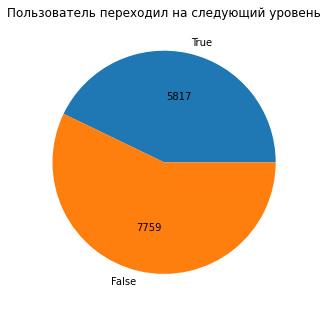

In [54]:
# Распределение клиентов по лвл-апам
fig = plt.gcf()
fig.set_size_inches(11,11)
ax2 = plt.subplot(1, 2, 1)
total = sum(lvlup_count['user_id'])
plt.pie(
    x=lvlup_count['user_id'], labels=lvlup_count['lvlup'],
    autopct=lambda p: '{:.0f}'.format(p * total / 100)
)
plt.title('Пользователь переходил на следующий уровень')
plt.show()

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
    
- Общая конверсия в целевое действие - 42.8%. Показатель не слишком высокий, его можно улучшить, например, ускорив или упростив переход на следующий уровень.
</div>

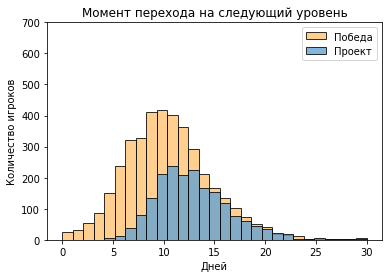

In [40]:
# Сравнение переходов на следующий уровень
x = game_finished.query('user_id not in @game_finished_project_ids')['time_delta']
y = game_finished.query('user_id in @game_finished_project_ids')['time_delta']
bins = np.linspace(0, 30, 30)
plt.title('Момент перехода на следующий уровень')
plt.ylim([0, 700])
plt.hist(x, bins, alpha=0.8, color="#FFC373", edgecolor='k', label='Победа')
plt.hist(y, bins, alpha=0.8, color="#66A3D2", edgecolor='k', label='Проект')
plt.xlabel('Дней')
plt.ylabel('Количество игроков')
plt.legend(loc='upper right')
plt.show()

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
    
- На данном этапе гипотеза о том, что переход на следующий уровень через проект занимает больше времени выглядит убедительно. Мы к ней еще вернемся, однако уже сейчас можно сказать, что тем, кто повышал уровень через проект потребовалось минимум 5 дней на выполнение задачи. В то время как через победу кто-то успевал за 1 день. У этого есть свои плюсы и минусы, которые распишу в выводах.
</div>

In [41]:
game_finished['time_delta'].describe()

count    5817.000000
mean       11.362214
std         4.080387
min         0.000000
25%         9.000000
50%        11.000000
75%        14.000000
max        30.000000
Name: time_delta, dtype: float64

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Среднее время перехода на следующий уровень - 11 дней. Одна из основных задач - целевое действие, то есть переход на следующий уровень, занимает довольно много времени. Возможно есть смысл ускорить время развития игроков (для этого не обязательно уменьшать количество действий в игре).

</div>

In [42]:
buildings_per_player = game_actions.groupby('user_id').agg({'building_type' : 'value_counts'})
buildings_per_player = buildings_per_player.rename(columns = {'building_type' : 'amount'}).reset_index()

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Ниже сравнение количества построек для игроков с разными условиями перехода (или не перехода) на следующий уровень.

</div>

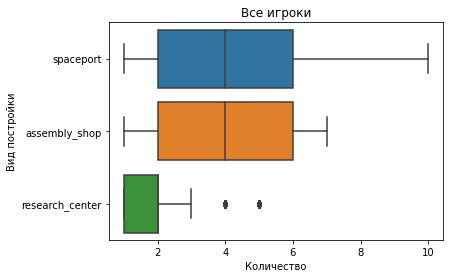

In [43]:
sns.boxplot(data=buildings_per_player, x="amount", y="building_type", order=['spaceport', 'assembly_shop', 'research_center'])
plt.xlabel("Количество")
plt.ylabel("Вид постройки")
plt.title("Все игроки")
plt.show()

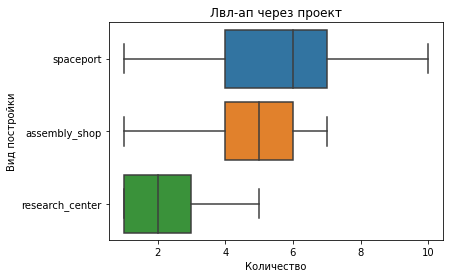

In [44]:
sns.boxplot(
    data=buildings_per_player.query(
        'user_id in @game_finished_project_ids'
    ), x="amount", y="building_type", order=['spaceport', 'assembly_shop', 'research_center']
)
plt.xlabel("Количество")
plt.ylabel("Вид постройки")
plt.title("Лвл-ап через проект")
plt.show()

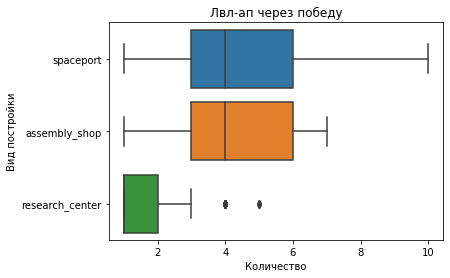

In [45]:
sns.boxplot(
    data=buildings_per_player.query(
        'user_id not in @game_finished_project_ids & user_id in @game_finished_ids '
    ), x="amount", y="building_type", order=['spaceport', 'assembly_shop', 'research_center']
)
plt.xlabel("Количество")
plt.ylabel("Вид постройки")
plt.title("Лвл-ап через победу")
plt.show()

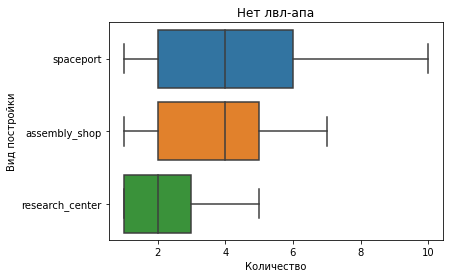

In [46]:
sns.boxplot(
    data=buildings_per_player.query(
        'user_id not in @game_finished_ids'
    ), x="amount", y="building_type", order=['spaceport', 'assembly_shop', 'research_center']
)
plt.xlabel("Количество")
plt.ylabel("Вид постройки")
plt.title("Нет лвл-апа")
plt.show()

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Средние и медианные показатели по количеству построенных зданий меньше всего у тех, кто не перешел на следующий уровень. Что было ожидаемо.
- Что интересно, медианные показатели у тех, кто получил лвл-ап через победу такие же, как и у тех, кто на следующий уровень не перешел.
- Те кто сделал проект, строили гораздо больше, особеннно спейспортов.
- Из этого напрашивается вывод, что, за более быстрый переход на следующий уровень через бой, мы платим меньшим количеством построек, то есть меньшим количеством показов рекламы.
</div>

## Проверка гипотез 
<a class="anchor" id="paragraph3"></a>

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
    
<b>Гипотеза №1</b>
    
- Среднее время перехода на следующий уровень отличается в зависимости от способа.
    
<b>Альтернативная Гипотеза №1</b>
    
- Среднее время перехода на следующий уровень не отличается в зависимости от способа.
    
</div>

In [47]:
alpha = 0.05

results = st.ttest_ind(game_finished_project['time_delta'], game_finished_battle['time_delta'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Среднее время перехода на следующий уровень отличается в зависимости от способа.")
else:
    print("Не получилось отвергнуть нулевую гипотезу. Нет оснований считать, что среднее время перехода на следующий уровень отличается в зависимости от способа.")

p-значение: 1.8882835392369192e-97
Отвергаем нулевую гипотезу. Среднее время перехода на следующий уровень отличается в зависимости от способа.


<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
    
- Как и предполагалось, есть значительная разница в скорости перехода на следующий уровень между теми, кто победил в битве и теми, кто закончил проект. Скорее всего, благодаря этому, больше людей переходит на следующий уровень через победу, в то время, как больше построек приходится на тех, кто переходит через проект. Каждая когорта выполняет одну из двух основных задач - окупаемость рекламы и быстрый переход в целевое действие. Убедимся, что количество построек выше у проекта ниже.
</div>

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
    
<b>Гипотеза №2</b>
    
- Количество построек отличается в зависимости от способа перехода на следующий уровень.
    
<b>Альтернативная Гипотеза №2</b>
    
- Количество построек не отличается в зависимости от способа перехода на следующий уровень.
    
</div>

In [48]:
buildings_battle = (
    buildings_per_player.query(
        'user_id not in @game_finished_project_ids & user_id in @game_finished_ids'
    ).groupby('user_id').agg({'amount' : 'sum'})
)

buildings_project = (
    buildings_per_player.query(
        'user_id in @game_finished_project_ids'
    ).groupby('user_id').agg({'amount' : 'sum'})
)

In [49]:
print('Количество построек, проект.')
print()
print('Среднее:', buildings_project.mean())
print()
print('Медианное:', buildings_project.median())

Количество построек, проект.

Среднее: amount    12.64791
dtype: float64

Медианное: amount    12.0
dtype: float64


In [50]:
print('Количество построек, бой.')
print()
print('Среднее:', buildings_battle.mean())
print()
print('Медианное:', buildings_battle.median())

Количество построек, бой.

Среднее: amount    9.411541
dtype: float64

Медианное: amount    10.0
dtype: float64


In [51]:
alpha = 0.05

results = st.ttest_ind(buildings_battle['amount'], buildings_project['amount'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Количество построек отличается в зависимости от способа перехода на следующий уровень.")
else:
    print("Не получилось отвергнуть нулевую гипотезу. Нет оснований считать, что количество построек отличается в зависимости от способа перехода на следующий уровень.")

p-значение: 0.0
Отвергаем нулевую гипотезу. Количество построек отличается в зависимости от способа перехода на следующий уровень.


<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Действительно, для проекта требуется больше построек и больше времени, поэтому количество построек у данной когорты значительно выше в среднем и по медиане. Это в свою очередь означает, что потенциальная прибыль с каждого такого игрока выше, чем с тех, кто выигрывают бои. С другой стороны, удержать таких пользователей может быть сложнее, так как целевое действие требует больше времени и количество рекламы до целевого действия значительно выше.
</div>

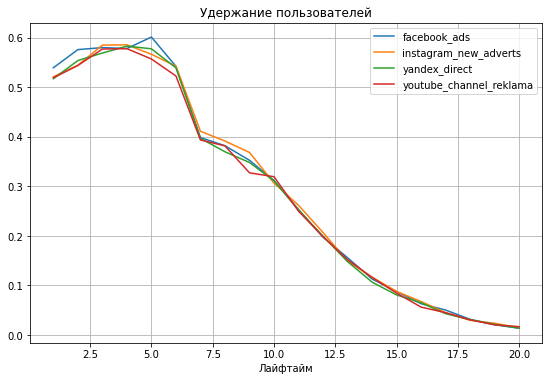

In [52]:
# смотрим удержание с разбивкой по источнику
dimensions = ['source']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, game_actions, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

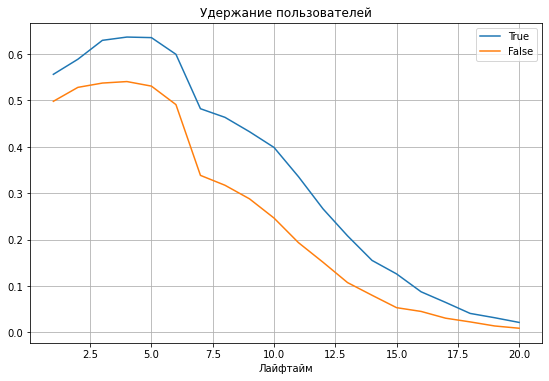

In [53]:
# смотрим удержание с разбивкой по лвл-апу
dimensions = ['lvlup']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, game_actions, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

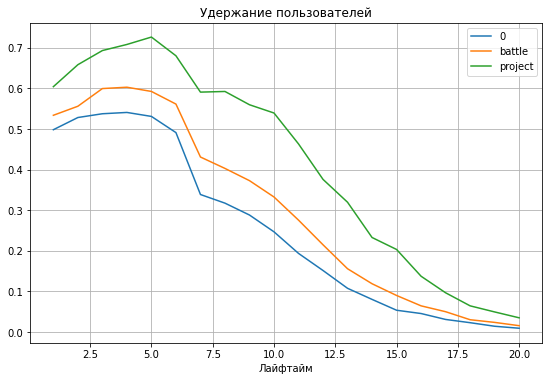

In [54]:
# смотрим удержание с разбивкой по способу лвл-апа
dimensions = ['condition']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, game_actions, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Показатели удержания среди тех, кто не получал лвл-ап и тех, кто получил его за победу очень близки. Выгодно выделяются те, кто делал проект. Скорее всего это связано с тем, что проект занимает больше времени, а также требует больше построек для выполнения задачи.
- Показатели удержания для разных источников практически идентичны.
- Важно учитывать, что это не чистый отток, так как после получения лвл-апа мы не видим действий пользователей.
</div>

## Формирование модели монетизации.
<a class="anchor" id="paragraph4"></a>

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
    
<b>Модель №1</b>

- Модель монетизации предложенная маркетологами, где каждая постройка имеет показ рекламы с доходностью в 0.07 долларов. Таким образом я рассматриваю каждую постройку как доход в 0.07 долларов и строю графики ROI и LTV исходя из этих параметров.
    
</div>

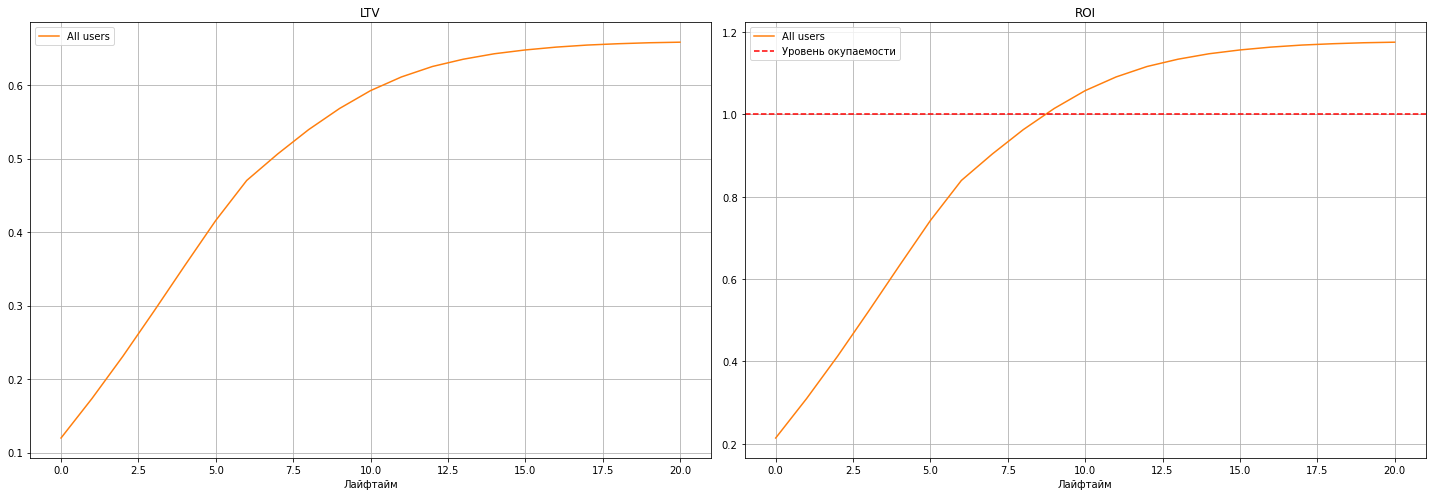

In [55]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, payments, observation_date, horizon_days)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
    
- Видно, что окупаемость наступает после 10 дня лайфтайма.
- Рост после 15 дня практически прекращается.
    
</div>

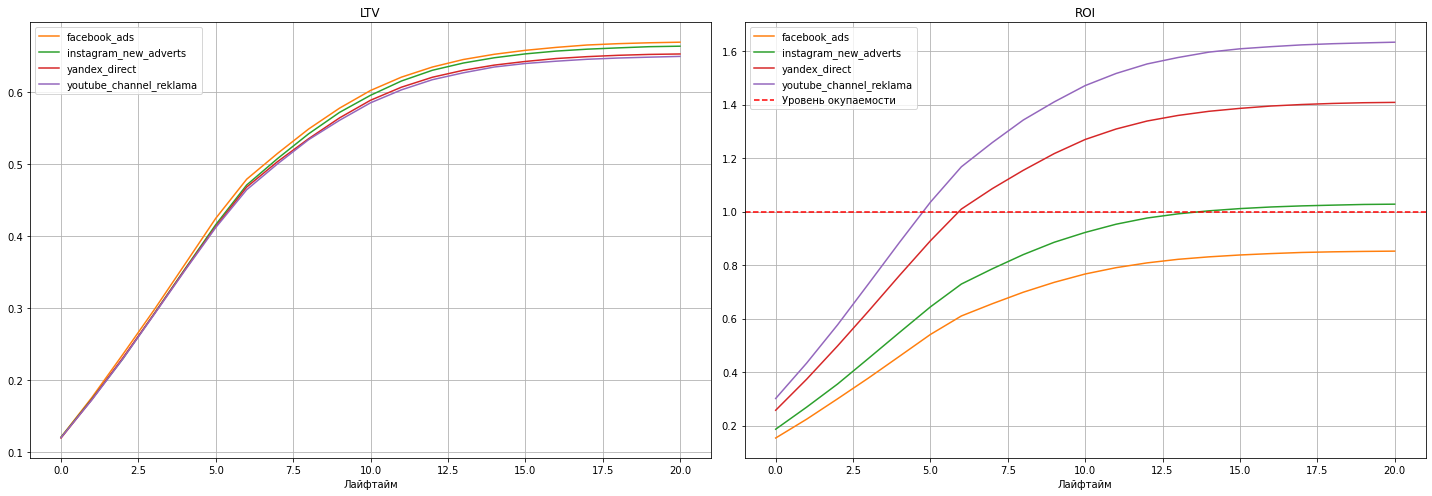

In [56]:
dimensions = ['source']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, payments, observation_date, horizon_days, dimensions=dimensions)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
    
- Facebook явно не окупается, находится в районе 0.8 ROI.
- Яндекс директ и Youtube однозначные лидеры по доходности (выше 1.4 ROI).
    
</div>

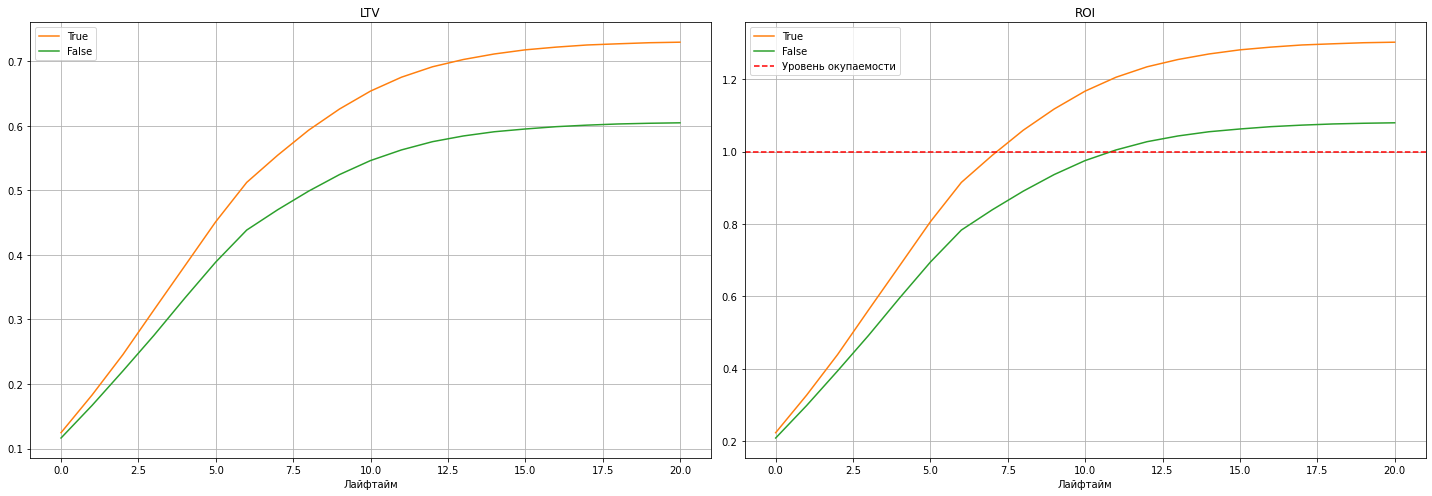

In [57]:
dimensions = ['lvlup']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, payments, observation_date, horizon_days, dimensions=dimensions)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

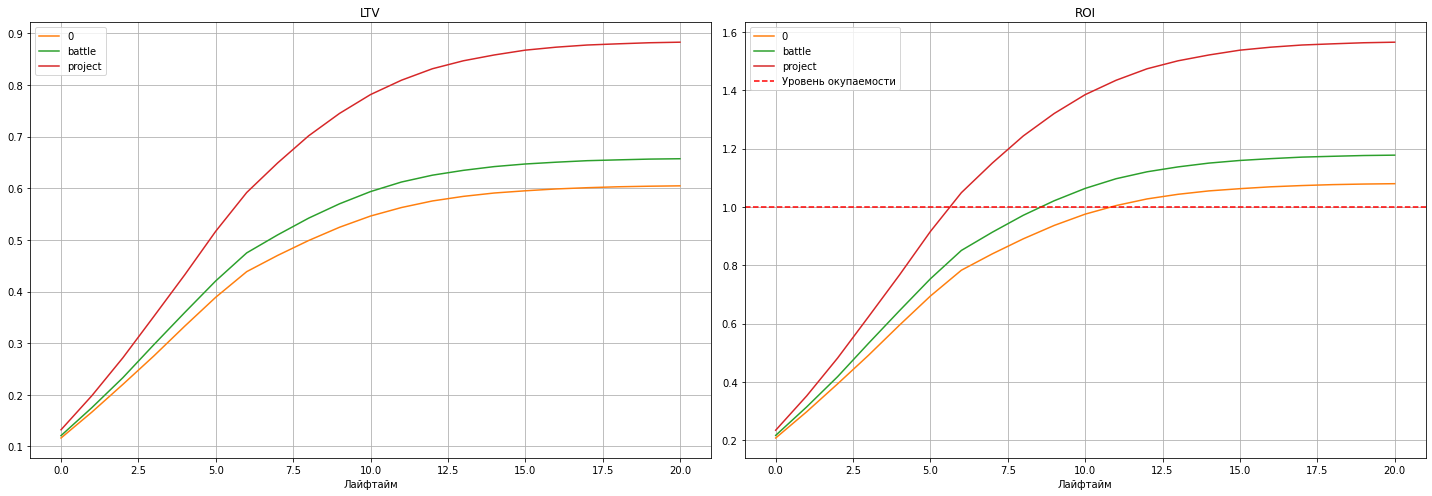

In [58]:
dimensions = ['condition']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, payments, observation_date, horizon_days, dimensions=dimensions)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
    
- Нет убыточных показателей вне зависимости от лвл-апа. Однако, те кто получил уровень через проект значительно более выгоден разработчику (почти 1.6 ROI).
    
</div>

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
    
<b>Модель №2</b>

- Поскольку значительное сокращение показов рекламы приведет к тому, что вложения в привлечене клиентов не окупятся. В таком случае я считаю, что модель при которой сокращается около 10% показов рекламы, может иметь больший потенциал привлечения и удержания клиентов без значительного урона для доходности.
- Модель: при первой постройке не происходит показа рекламы, при дальнейших постройках реклама показывается.
    
</div>

In [59]:
payments_min = payments.groupby('user_id').agg({'event_datetime':'min'}).reset_index()

In [60]:
payments_after_first = (
    pd.merge(payments, payments_min, on=['user_id','event_datetime'], how='outer', indicator=True)
       .query("_merge != 'both'")
       .drop('_merge', axis=1)
       .reset_index(drop=True)
)

In [61]:
game_actions_after_first = game_actions.drop(columns = ['revenue'])
game_actions_after_first = game_actions_after_first.merge(payments_after_first, on=['event_datetime', 'user_id'], how='outer')
game_actions_after_first['revenue'] = game_actions_after_first['revenue'].fillna(0)

In [62]:
# Создаю профили
profiles_after_first = get_profiles(game_actions_after_first, payments_after_first, ad_cost)

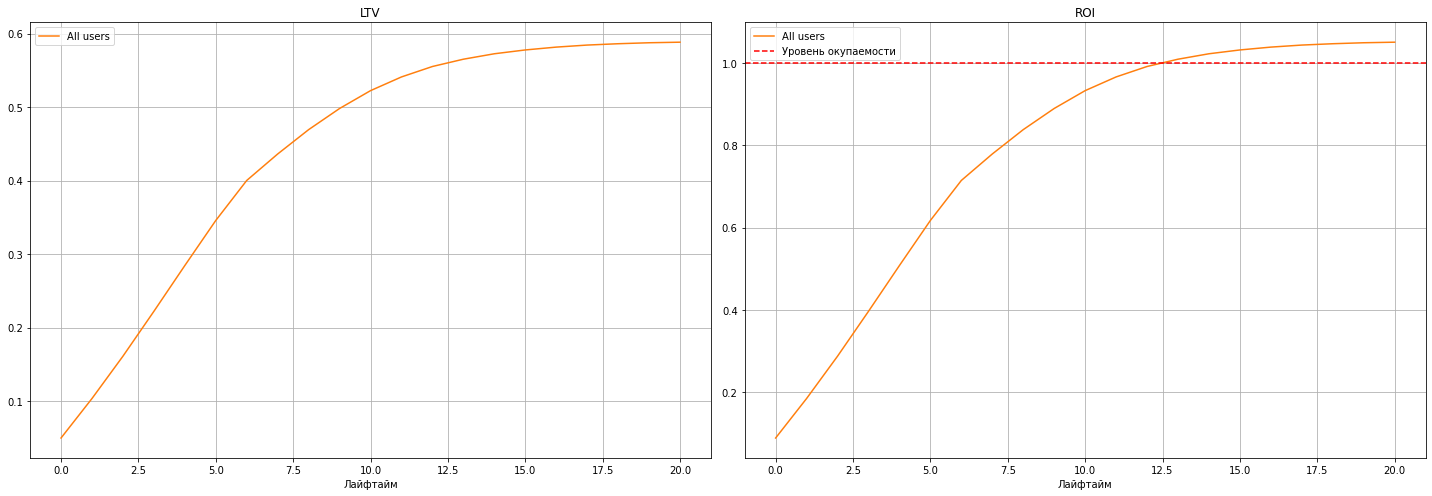

In [63]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_after_first, payments_after_first, observation_date, horizon_days)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
    
- Практически нулевая прибыль, однако все еще ROI выше 1.
    
</div>

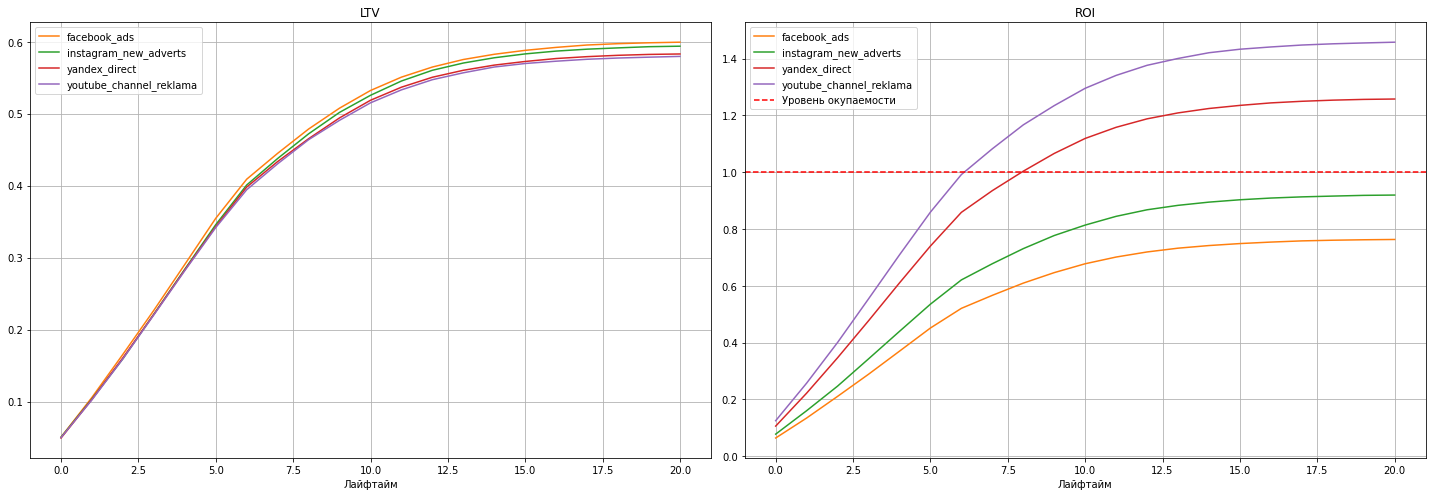

In [64]:
dimensions = ['source']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_after_first, payments_after_first, observation_date, horizon_days, dimensions=dimensions)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
    
- Instagram из нулевой прибыли в 1ой модели перешел в 0.9 ROI, то есть убыток.
    
</div>

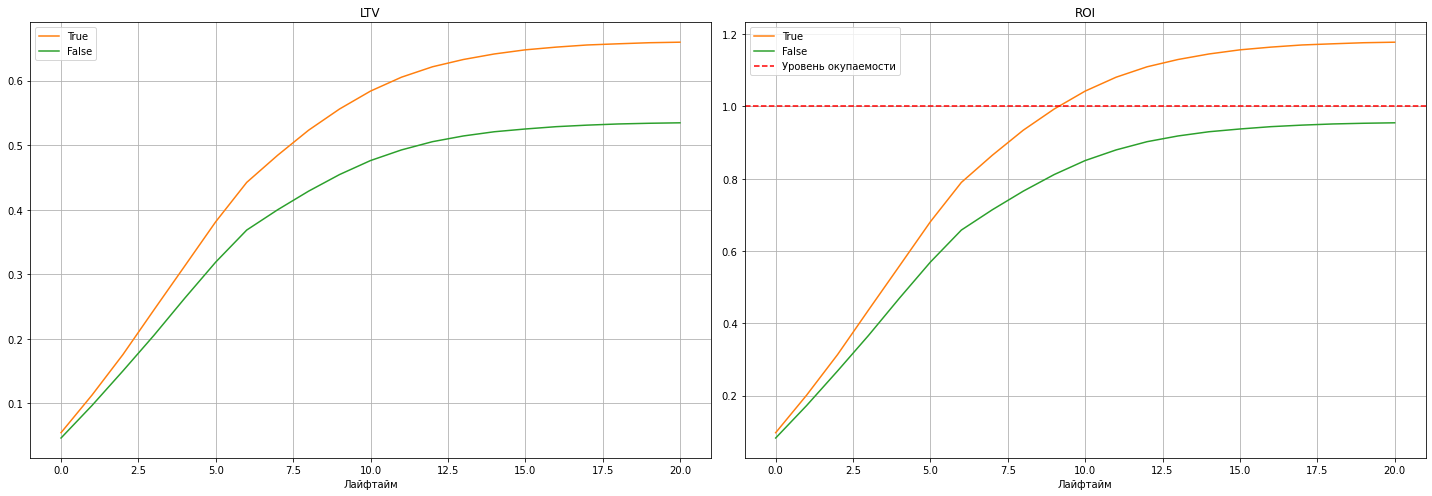

In [65]:
dimensions = ['lvlup']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_after_first, payments_after_first, observation_date, horizon_days, dimensions=dimensions)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

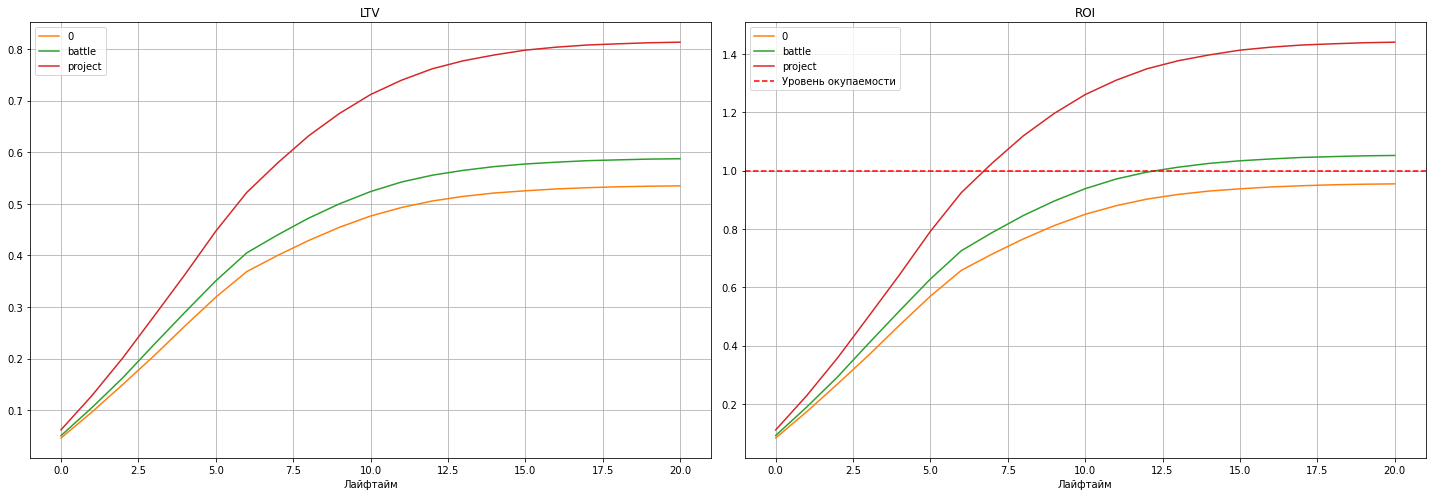

In [66]:
dimensions = ['condition']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_after_first, payments_after_first, observation_date, horizon_days, dimensions=dimensions)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
    
- При данной модели по настоящему прибыльными остались только пользователи, сделавшие проект. Остальные находятся в районе ROI равному 1.
</div>

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
    
- На данном этапе, если ввести рекламу при постройке каждого здания, то реклама будет с трудом окупаться. Исходя из поставленной задачи: не потерять слишком много клиентов, кто переходит на следующий уровень и окупить рекламу хотя бы в 0, данный подход удовлетворит обе задачи. Есть вероятность потерять часть игроков, особенно среди тех, кто делает проекты, так как они строят больше всего. С другой стороны, те кто получают уровень в бою не так ощутят рекламу, а они и есть те, кто получает уровень быстрее всего.
- Таким образом в игре есть некоторый баланс: больше денег приходит от тех, кто идет через проект, но их мало и они получают уровень дольше. То есть они больше задействованы в окупании рекламы и меньше в получении уровня. Меньше денег приносят все остальные, однако, те кто воюют, получают уровень быстро, удовлетворяя нашу потребность в быстром достижении целегого действия.
- Если уменьшить количество рекламы незначительно, то мы будем выходить в 0. Однако, с учетом того, что часть клиентов перестанет играть из-за рекламы, то это значение будет уже ниже 0. С другой стороны, мы не можем знать, сколько клиентов мы потеряем на первой же рекламе при первой использовании первой модели. При рассмотрении других моделей (например, реклама на определенный тип зданий или на каждую вторую постройку, ROI падает с 1.2 до 0.6 и это без учета оттока клиентов.
- Facebook на данный момент не окупается, как источник привлечения клиентов. Возможно, стоит рассмотреть другой объем вложений в рекламу на этом источнике или же другой подход к рекламе.
</div>


<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
    
- **Выбор модели:**
- Я склоняюсь к тому, что предложенная мной модель более оптимальна. Сравнивая с моделью, предложенной маркетологами:
- Ее плюсы:
    - Не столь агрессивная, при первом открытии постройки игрока не встречает реклама и он хоть немного успевает познакомится с игрой.
    - Есть шанс удержать игроков, которые при первой модели сразу поймут, что реклама будет появлятся каждый раз и быстро покинут игру. При второй модели игроку потребуется несколько построек, чтобы понять, что реклама после 1 постройки гарантирована, а не возникает рандомно / раз в несколько построек.
    - Игрок оказывается более вовлечен в игру, прежде, чем сталкивается с первой рекламой. Чем больше в игру вложено времени и сил, тем сложнее ее покинуть. В случае, если первая реклама возникает во время первой постройки, игроку ничего не стоит закрыть игру и забыть про нее, так как в нее не было вложено время, игрок не чувствует что теряет что либо.
- Ее минусы:
    - Игрок может почувствовать себя обманутым, так как при первой постройке он не получил рекламу, а потом получает ее постоянно и покинет игру.
- Дополнительно:
    - Если игрока сильно отталкивает реклама и это единственная причина, почему он покидает игру, мы не теряем такие показы. Так как либо он закроет игру после первой постройки (=первой рекламы), либо после второй постройки(=первой рекламы). На таких игроков обе модели действуют одинаково. 
    - Если игрок, после первой постройки закрывает игру вне зависимости от рекламы, мы теряем такого игрока без какого либо дохода от него. Это может оказаться минусом моей модели. Однако, на мой взгляд, это невелируется тем, что мы сохраним часть игроков как минимум на несколько дополнительных построек из-за плюсов, что я указал выше. 
</div>


## Общие выводы.
<a class="anchor" id="paragraph6"></a>

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- На данном этапе, предлагаемая система монетизации имеет смысл. Один показ рекламы на одну постройку окупает рекламу с небольшим профицитом. Предложенная мной модель тоже имеет свои плюсы и минусы относительно первой, часть из которых я описал выше.
- Наиболее быстрый переход в целевое действие у тех, кто выигрывает бой. Игроки, выбравшие проект переходят на следующий уровень ощутимо дольше.
- Игроков, которые повысили уровень через бой больше, чем через проект.
- Несмотря на то, что удержание среди разных источников почти идентично, доходность у них отличается. Таким образом Фейсбук не окупает затраты на рекламу, в то время как Ютьюб и Яндекс являются наиболее доходными источниками.
- Удержание игроков через проект значительно выше, чем через бой. Вторые строят (в нашем случае == приносят доход с рекламы), почти столько же, сколько и те, кто не повысил уровень.
</div>

## Рекомендации.

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Для улучшения конверсиим можно сократить время развития для проекта. Например, сократить время построек, в таком случае игроки будут переходить на следующий уровень быстрее, при этом, количество построек(=рекламы) не уменьшится. Это изменение заденет и всех остальных игроков, так как развитие ускорится для всех. Это может стать фактором, который позволит большему числу игроков переходить на следующий уровень.
- Для улучшения окупаемости можно добавить 1 дополнительную постройку, тем, кто получает уровень через победу. Это будет около 10% дополнительного дохода, но повысит риски потери этих игроков. Я бы не рекомендовал эту опцию, но она имеет право на существование.
- Для улучшение окупаемости можно уменьшить вложения в рекламу на Фейсбук и в Инстаграме. Или же изменить формат рекламы для этих источников. Оба источника значительно уступают по окупаемости двум другим. Из этого следует вывод, что можно рассмотреть большее вложение в рекламу на Яндекс и Ютьюб.
- Для улучения удержания можно использовать предложенную мной модель монетизации, то есть отказаться от показа рекламы при первой постройке. С одной стороны это не будет отталкивать игрока в первые же секунды игры, с другой, может вызвать бОльшую неприязнь, после нескольких следующих построек и осознания, что реклама высвечивается постоянно. Отказ от первой рекламы не приведет к дефициту (потеря дохода около 10%) и затраты на привлечение все еще будут окупаться в ноль или небольшой плюс. Это повысит вероятность большего числа построек на начальном этапе, а это выполняет сразу 2 задачи - приблежение к целевому действию и окупаемость привлечения клиентов. 
</div>